# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import random

In [2]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

IMAGE_SIZE = (32,32)

In [23]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 10

In [36]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\Prof\\data\\seg_train\\"
TEST_PATH = ROOT_PATH + "\\Prof\\data\\seg_test\\"

In [37]:
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [38]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

filenames

files = []

# Lista vacia
categories = []

# Iterar
for filename in filenames:    
    # If else
    # Guardo en lista
    files_in_directory = os.listdir(TRAIN_PATH + '\\' + filename)
    for file in files_in_directory:
        files.append(file)
        if filename == 'buildings':
            categories.append(0)
        elif filename == 'forest':
            categories.append(1)
        elif filename == 'glacier':
            categories.append(2)
        elif filename == 'mountain':
            categories.append(3)
        elif filename == 'sea':
            categories.append(4)
        else:
            categories.append(5)
    
    
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [39]:
df

,filename,category
0,0.jpg,0
1,10006.jpg,0
2,1001.jpg,0
3,10014.jpg,0
4,10018.jpg,0
...,...,...
14029,9961.jpg,5
14030,9967.jpg,5
14031,9978.jpg,5
14032,9989.jpg,5


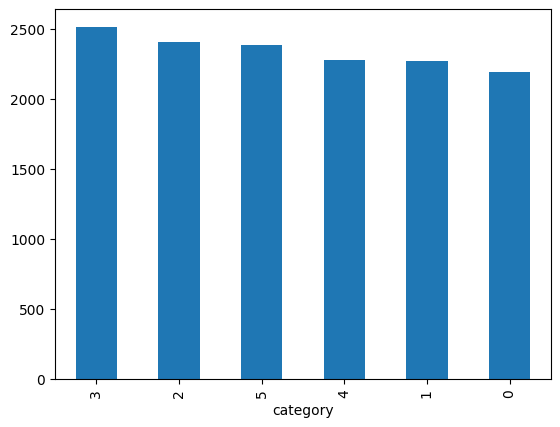

In [40]:
df['category'].value_counts().plot.bar();

In [62]:
def read_data(path, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for directorie in os.listdir(path):
        files_in_directory = os.listdir(path + '\\' + directorie)
        for file in files_in_directory:
            # Leer la imagen a color y aplicarle el resize
            image = imread(path + '\\' + directorie + '\\' + file)
            smallimage = cv2.resize(image, (im_size, im_size))
            
            # Guardo en X
            X.append(smallimage)
            Y.append(class_names_label.get(directorie))        

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


(32, 32, 3)


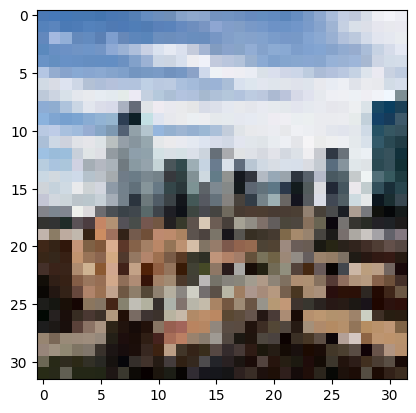

In [54]:
print(X_train[0].shape)
plt.imshow(X_train[1]);

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [63]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [64]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [65]:
y_train

array([3, 1, 1, ..., 2, 3, 0])

In [66]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

In [67]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [74]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [75]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [76]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.h5")

In [77]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2,
         verbose=1)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\cgdo2\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\cgdo2\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\cgdo2\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\cgdo2\AppData\Local\Temp\ipykernel_27012\3977295992.py", line 1, in <module>

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "c:\Users\cgdo2\Documents\Master Data\DS_PT_09_2023\.venv\Lib\site-packages\keras\src\backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of 5 which is outside the valid range of [0, 1).  Label values: 1 2 5 0 5 2 4 0 1 5 1 2 5 3 0 2 3 1 1 3 1 2 1 1 3 4 4 1 2 3 5 3
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_49263]

In [72]:
results = model.evaluate(X_test, y_test)
results

94/94 [==============================] - 0s 5ms/step - loss: -5155470180352.0000 - accuracy: 0.1670


[-5155470180352.0, 0.16699999570846558]

In [73]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

94/94 [==============================] - 0s 4ms/step


array([[  0, 525,   0,   0,   0,   0],
       [  0, 501,   0,   0,   0,   0],
       [  0, 553,   0,   0,   0,   0],
       [  0, 437,   0,   0,   0,   0],
       [  0, 510,   0,   0,   0,   0],
       [  0, 474,   0,   0,   0,   0]], dtype=int64)